In [9]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
import matplotlib as mpl

#Read in the data
df = pd.read_csv('Footballdata/Others/GermanyvsJapan2.csv', encoding='latin-1')

#remove unnecessary actions
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'FormationSet')]
df = df.loc[~(df['type/displayName'] == 'Start')]
df = df.loc[~(df['type/displayName'] == 'End')]

#Set time period (if needed)
#df = df.loc[df['period/displayName'] == 'FirstHalf']
#df = df.loc[df['period/displayName'] == 'SecondHalf']

#Finding previous event to filter out setpieces
df['prevevent'] = df['type/displayName'].shift(1)

#Check previous team to ensure it is not from the same team later on
df['prevteam'] = df['teamId'].shift(1)

#Check previous team to ensure it is not from the same team later on
df['prevteam2'] = df['teamId'].shift(2)

#Change Offside Passes to Passes
df = df.replace('OffsidePass', 'Pass')

#Remove corner kicks
df = df.loc[~(df['x']==99.5)]

#Remove throw-ins
df = df.loc[(df['y'].between(0.1,99.9))]

#Remove passes that come after fouls and cards, potential set pieces
df = df.loc[~((df['type/displayName'] == 'Pass') & (df['prevevent'] == 'Foul'))]
df = df.loc[~((df['type/displayName'] == 'Pass') & (df['prevevent'] == 'Card'))]

#Only obtaining defensive actions happening beyond 40% of the pitch for team in question
df1 = df.loc[(df['x']>40)]

#Calculating passes that occur below 60% of the pitch for opposition
df2 = df.loc[(df['x']<60)]

#Combo box, choose team
options = df["teamId"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
teamlist = widgets.Combobox(
    placeholder='Enter a team',
    options=options,
    description='Team:',
    ensure_option=True,
    disabled=False
)
teamlist

Combobox(value='', description='Team:', ensure_option=True, options=('Germany', 'Japan'), placeholder='Enter a…

In [10]:
#Remove Warning
pd.options.mode.chained_assignment = None

#Retrieve Team
team = teamlist.value

#Retrieve Opposition team (only use when there's two available teams for selection)
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

#List down relevant defensive actions
list1 = ["Interception","Tackle","Foul","Challenge",'BlockedPass']

#Get total of defensive actions
Defensive_Actions1 = df1.loc[((df1['teamId'] == team ) & (df1['type/displayName'].isin(list1)) & (df1['prevteam'] == oppo))]

#Remove Fouls that are successful, not traditional fouls
Defensive_Actions1 = Defensive_Actions1.loc[~((Defensive_Actions1['type/displayName'] == 'Foul') &
                                             (Defensive_Actions1['outcomeType/displayName'] == 'Successful'))]

#Filter for Aerials that occur when player competes, need to make sure they are attempting to intercept a pass 
Headers1 = df1.loc[(df1['teamId'] == team) &
                   (df1['type/displayName'] == 'Aerial') &
                   (df1 ['outcomeType/displayName'] == 'Unsuccessful') &
                   (df1['prevevent'] == 'Aerial') &
                   (df1['prevteam'] == oppo)]

#take out headers that are failed. Intended to pass to them but failed their duel
Headers1 = Headers1.loc[~((Headers1['prevteam2'] == team))]

#Filter for Aerials that occur when player intercepts a high ball, or wins an aerial duel
Headers2 = df1.loc[(df1['teamId'] == team) &
                   (df1['type/displayName'] == 'Aerial') &
                   (df1 ['outcomeType/displayName'] == 'Successful') &
                   (df1['prevteam'] == oppo)]

#combining the two dataframes
Headers = [Headers1 , Headers2]
Headers = pd.concat(Headers)

#Take out headers inside the attacking box, likely set piece headers
Headers = Headers.loc[~((Headers['y'].between(21.25,78.75) & (Headers['x'] > 85.83)))]

#Combining aerials with the rest of the defensive actions
Defensive_Actions2 = [Defensive_Actions1 , Headers]
Defensive_Actions = pd.concat(Defensive_Actions2)

#Get total
action = len(Defensive_Actions.index)

In [11]:
#Get total of opposition passes (not sure if we should include successful passes)
Passes_Allowed = df2.loc[((df2['teamId'] == oppo) & (df2['type/displayName'] == 'Pass'))]
#Passes_Allowed = df2.loc[((df['teamId'] == oppo) & (df2['type/displayName'] == 'Pass') & (df['outcomeType/displayName'] == 'Successful'))]
passes = len(Passes_Allowed.index)

#Calculating PPDA
PPDA = passes / action
PPDA =  round(PPDA, 2)

#Overview
print(team)
print("Passes Allowed: "+ str(passes))
print("Defensive Actions: "+ str(action))
print("PPDA: "+ str(PPDA))

Japan
Passes Allowed: 508
Defensive Actions: 31
PPDA: 16.39


In [7]:
#Adjust for pitch size
Defensive_Actions['x'] = Defensive_Actions['x']*1.2
Defensive_Actions['y'] = Defensive_Actions['y']*.8

Passes_Allowed['x'] = Passes_Allowed['x']*1.2
Passes_Allowed['y'] = Passes_Allowed['y']*.8
Passes_Allowed['endX'] = Passes_Allowed['endX']*1.2
Passes_Allowed['endY'] = Passes_Allowed['endY']*.8

#Need home team to be displayed on the left, so need to find the absolute values
Passes_Allowed['x'] = Passes_Allowed['x']-120
Passes_Allowed['y'] = Passes_Allowed['y']-80
Passes_Allowed['x'] = Passes_Allowed['x'].abs()
Passes_Allowed['y'] = Passes_Allowed['y'].abs()

#Want to obtain Kit Number for annotation purposes on defensive actions
Def = Defensive_Actions[['playername','Kit Number','x','y']].reset_index(drop=True)
Def.rename(columns = {'Kit Number':'Num'},inplace = True)
Def['Num'] = Def['Num'].astype(int)
Def.index += 1

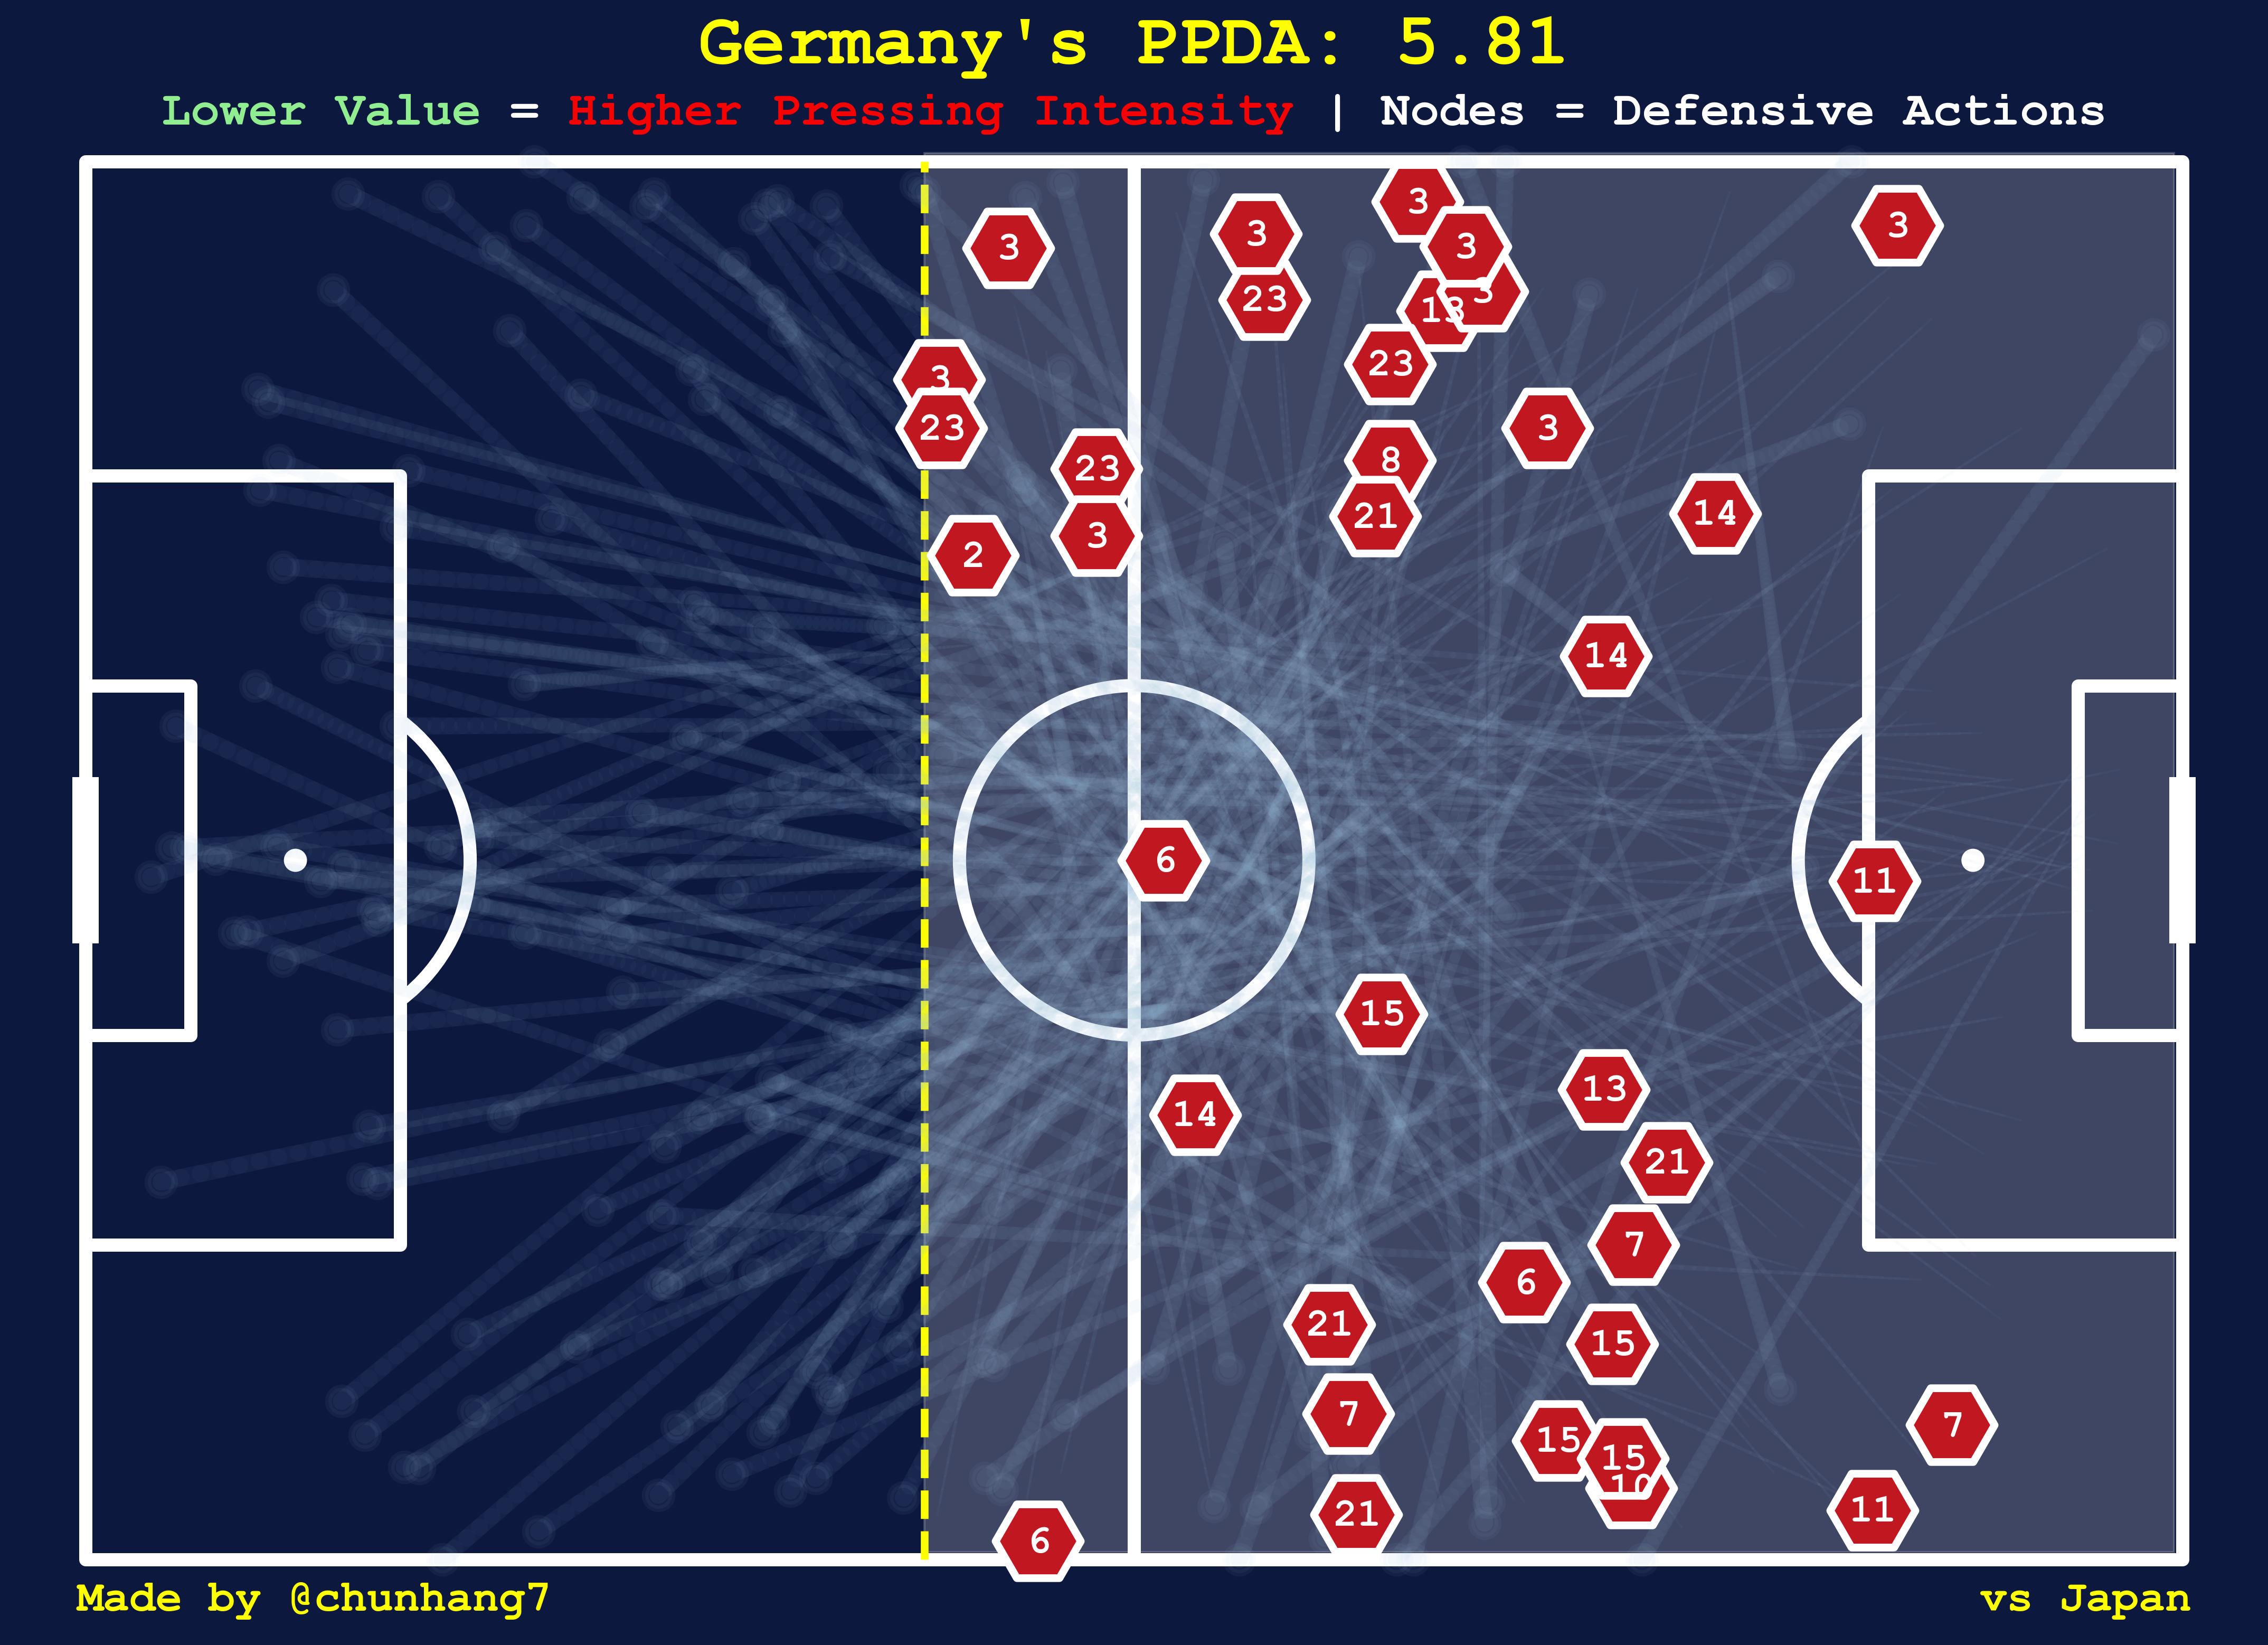

In [8]:
#dpi
mpl.rcParams['figure.dpi'] = 300

#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(15, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Draw line
ax.plot([48,48], [0, 80], c='yellow', lw=3.5,ls='--')

#inverse y-axis
plt.gca().invert_yaxis()

#plot the team's defensive actions
plt.scatter(Defensive_Actions.x, Defensive_Actions.y, marker='H', s=1500, c='#c11720', 
            linewidth = 3.5, edgecolor='w',zorder=5)

#plot passes made by opposition
pitch.lines(Passes_Allowed.x,Passes_Allowed.y,Passes_Allowed.endX,Passes_Allowed.endY,
            comet=True,ax=ax, linewidth=8, capstyle='round', zorder=2,
            alpha=0.03, color ='#aacfec')

pitch.scatter(Passes_Allowed['endX'], Passes_Allowed['endY'],
              edgecolors= "#aacfec", c="#aacfec", s = 150, zorder=2, ax=ax, 
              marker = 'o', alpha = 0.05,linewidths=3)

#shade
plt.axvspan(48,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Kit Numbers on Nodes
for index, row in Def.iterrows():
    pitch.annotate(row.Num, xy=(row.x+0.05,row.y-0.15), c='w', va='center', ha='center', 
                   size=18, fontweight='bold', fontfamily="Courier New",ax=ax,zorder=6)
                                    
#Title & Annotations
fig.suptitle(team +"'s PPDA: "+str(PPDA)+"\n", fontsize=33, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",y=0.94)

#highlights
highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'},
     {"color": "#f60000","fontweight": 'bold'}
    ]

Title = fig_text(s = "<Lower Value> = <Higher Pressing Intensity> | Nodes = Defensive Actions" ,
        x = 0.5, y = 0.895, highlight_textprops = highlight_textprops ,color='w',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=22);

#Annotations
fig.text(0.255, 0.03, 'Made by @chunhang7', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

fig.text(0.945, 0.03,'vs ' + oppo, fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

plt.show()